# Evaluating ResNet-18
##### Authors: Hyunsung Oh, Andrew Teoh, Ujjaini Das

### Part A: Architecture & Training Focus

In [ ]:
import torch
from torch import nn
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
seed = 42

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [3]:
from torchvision import datasets, transforms

save_dir = 'cifar10_data'

transform = transforms.ToTensor()

train_set = datasets.CIFAR10(save_dir, download=True, train=True, transform=transform)
test_set = datasets.CIFAR10(save_dir, download=True, train=False, transform=transform)

print(train_set)
print(test_set)

100%|██████████| 170M/170M [00:03<00:00, 51.2MB/s]


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: cifar10_data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: cifar10_data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [4]:
from torch.utils.data.sampler import SubsetRandomSampler

ntotal = 50000
ntrain = int(0.9*ntotal)
nval = ntotal - ntrain

val_ix = np.random.choice(range(ntotal), size=nval, replace = False)
train_ix = list(set(range(ntotal)) - set(val_ix))

train_sampler = SubsetRandomSampler(train_ix)
val_sampler = SubsetRandomSampler(val_ix)

print(len(train_sampler), len(val_sampler))

45000 5000


In [5]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=val_sampler)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)

In [12]:
from torchvision.models.resnet import ResNet, BasicBlock

First, let's create a modified ResNet-18 class!

In [13]:
class ModifiedResNet18(ResNet):
  def __init__(self, layers=[2, 2, 2, 2], remove_layers=[False, False, False, False], widths=[64, 128, 256, 512], out_features=10):
    super().__init__(block=BasicBlock, layers=layers, num_classes=out_features)

    self.inplanes = widths[0]
    self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
    self.bn1 = nn.BatchNorm2d(self.inplanes)

    if remove_layers[0]:
      self.layer1 = nn.Identity()
    else:
      self.layer1 = self._make_layer(BasicBlock, widths[0], layers[0])
    if remove_layers[1]:
      self.layer2 = nn.Identity()
    else:
      self.layer2 = self._make_layer(BasicBlock, widths[1], layers[1], stride=2)
    if remove_layers[2]:
      self.layer3 = nn.Identity()
    else:
      self.layer3 = self._make_layer(BasicBlock, widths[2], layers[2], stride=2)
    if remove_layers[3]:
      self.layer4 = nn.Identity()
    else:
      self.layer4 = self._make_layer(BasicBlock, widths[3], layers[3], stride=2)

    i = 3
    while i > 0 and remove_layers[i]:
      i -= 1
    self.fc = nn.Linear(in_features=widths[i], out_features=out_features)

  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)

    x = self.avgpool(x)
    x = torch.flatten(x, 1)
    x = self.fc(x)
    return x

Now let's create the training and testing methods!

In [14]:
def train_network(model, train_loader, val_loader, criterion, optimizer, nepoch=10):
  train_losses, val_losses = [], []
  try:
    model.train()
    for epoch in range(nepoch):
      print('EPOCH %d'%epoch)
      total_loss = 0
      count = 0
      for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        count += 1
      print('{:>12s} {:>7.5f}'.format('Train loss:', total_loss/count))
      train_losses.append(total_loss/count)

      with torch.no_grad():
        total_loss = 0
        count = 0
        for inputs, labels in val_loader:
          outputs = model.forward(inputs)
          loss = criterion(outputs, labels)
          total_loss += loss.item()
          count += 1
        print('{:>12s} {:>7.5f}'.format('Val loss:', total_loss/count))
        val_losses.append(total_loss/count)
      print()
  except KeyboardInterrupt:
    print('Exiting from training early')
  return train_losses, val_losses

def test_network(model, test_loader):
  model.eval()
  total, correct = 0, 0
  true, pred = [], []
  with torch.no_grad():
    for inputs, labels in test_loader:
      outputs = model.forward(inputs)
      predicted = torch.argmax(outputs, dim=1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
      true.append(labels)
      pred.append(predicted)
  acc = correct / total * 100
  print('Test accuracy: %0.3f'%acc)
  true = np.concatenate(true)
  pred = np.concatenate(pred)
  return acc, true, pred

Let's create a function to plot the losses!

In [15]:
def plot_losses(train_losses, val_losses):
  plt.plot(train_losses)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Train loss')
  plt.show()

  plt.plot(val_losses)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Val loss')
  plt.show()

1. Block Removal

Let's try removing each of the 4 residual blocks and seeing what happens. Let's create the 4 models, train them, and test them.

In [16]:
model1 = ModifiedResNet18(remove_layers=[True, False, False, False])
model2 = ModifiedResNet18(remove_layers=[False, True, False, False])
model3 = ModifiedResNet18(remove_layers=[False, False, True, False])
model4 = ModifiedResNet18(remove_layers=[False, False, False, True])

EPOCH 0
 Train loss: 1.39430
   Val loss: 1.12610

EPOCH 1
 Train loss: 1.01181
   Val loss: 0.96324

EPOCH 2
 Train loss: 0.84577
   Val loss: 0.86765

EPOCH 3
 Train loss: 0.71823
   Val loss: 0.83986

EPOCH 4
 Train loss: 0.61089
   Val loss: 0.80661

EPOCH 5
 Train loss: 0.50915
   Val loss: 0.80643

EPOCH 6
 Train loss: 0.42020
   Val loss: 0.82855

EPOCH 7
 Train loss: 0.35294
   Val loss: 0.92299

EPOCH 8
 Train loss: 0.28216
   Val loss: 0.94846

EPOCH 9
 Train loss: 0.22593
   Val loss: 0.99645

Test accuracy: 74.960


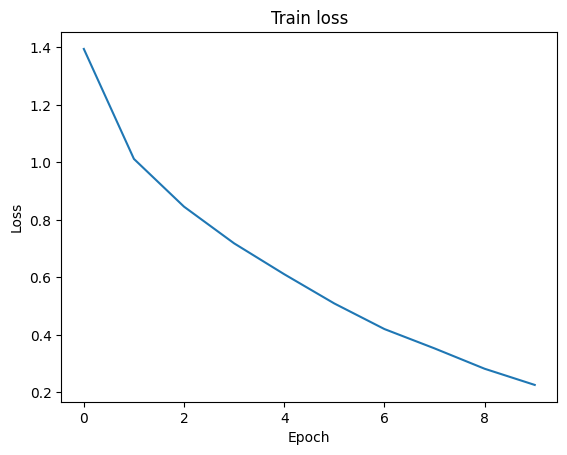

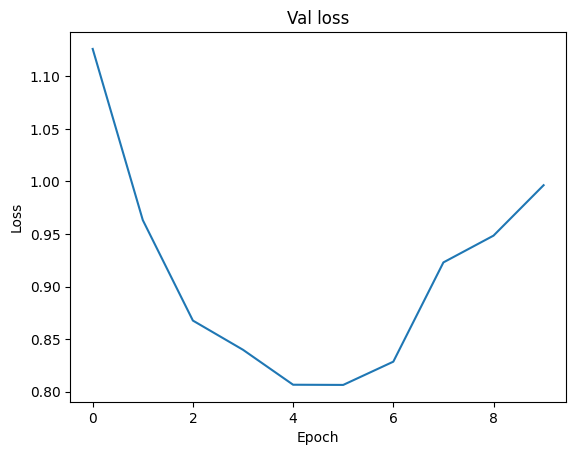

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=0.001)

losses1 = train_network(model1, train_loader, val_loader, criterion, optimizer, nepoch=10)
results1 = test_network(model1, test_loader)

plot_losses(losses1[0], losses1[1])

EPOCH 0
 Train loss: 1.32711
   Val loss: 1.11186

EPOCH 1
 Train loss: 0.94449
   Val loss: 0.89306

EPOCH 2
 Train loss: 0.76881
   Val loss: 0.78485

EPOCH 3
 Train loss: 0.63630
   Val loss: 0.76709

EPOCH 4
 Train loss: 0.52579
   Val loss: 0.74678

EPOCH 5
 Train loss: 0.41384
   Val loss: 0.73526

EPOCH 6
 Train loss: 0.31093
   Val loss: 0.75433

EPOCH 7
 Train loss: 0.22576
   Val loss: 0.86843

EPOCH 8
 Train loss: 0.17108
   Val loss: 0.93308

EPOCH 9
 Train loss: 0.12881
   Val loss: 0.93818

Test accuracy: 76.110


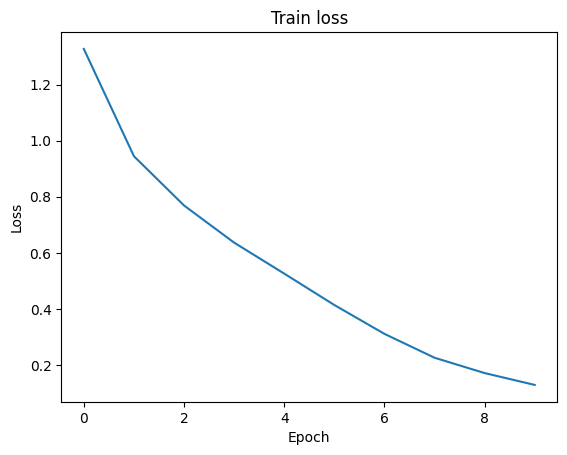

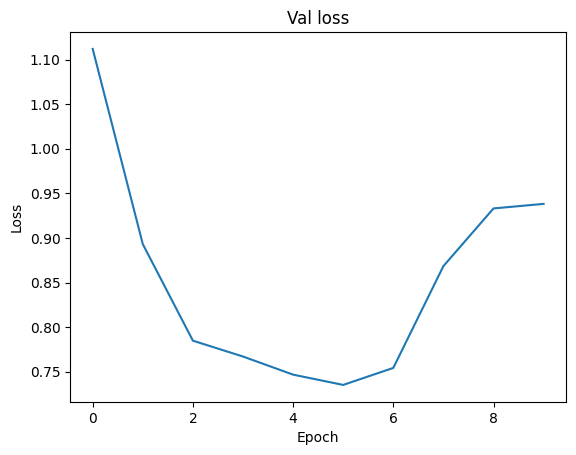

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)

losses2 = train_network(model2, train_loader, val_loader, criterion, optimizer, nepoch=10)
results2 = test_network(model2, test_loader)

plot_losses(losses2[0], losses2[1])

EPOCH 0
 Train loss: 1.33912
   Val loss: 1.05922

EPOCH 1
 Train loss: 0.95804
   Val loss: 0.92310

EPOCH 2
 Train loss: 0.78206
   Val loss: 0.81419

EPOCH 3
 Train loss: 0.65413
   Val loss: 0.72745

EPOCH 4
 Train loss: 0.54401
   Val loss: 0.72005

EPOCH 5
 Train loss: 0.44828
   Val loss: 0.70870

EPOCH 6
 Train loss: 0.35145
   Val loss: 0.75901

EPOCH 7
 Train loss: 0.27543
   Val loss: 0.79237

EPOCH 8
 Train loss: 0.21283
   Val loss: 0.91149

EPOCH 9
 Train loss: 0.16532
   Val loss: 0.95700

Test accuracy: 76.890


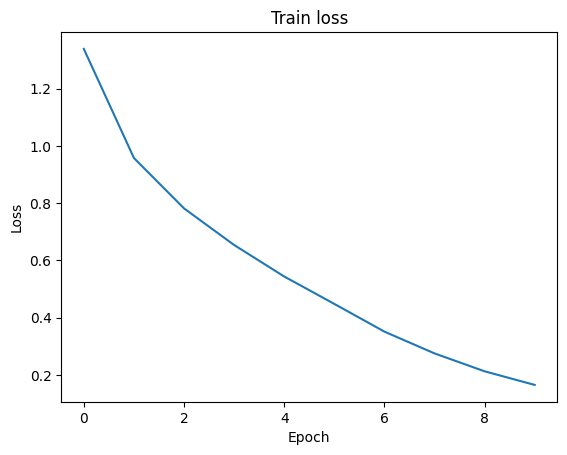

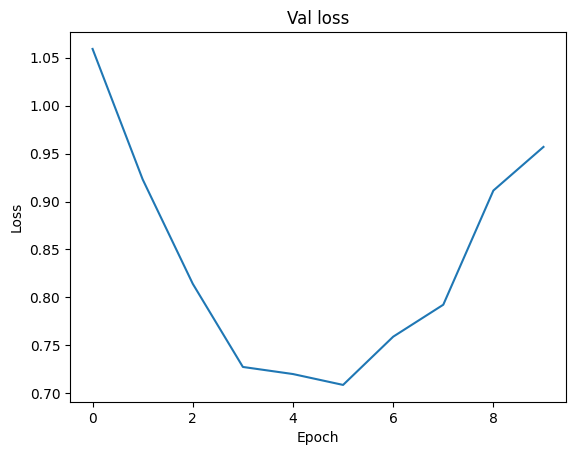

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model3.parameters(), lr=0.001)

losses3 = train_network(model3, train_loader, val_loader, criterion, optimizer, nepoch=10)
results3 = test_network(model3, test_loader)

plot_losses(losses3[0], losses3[1])

EPOCH 0
 Train loss: 1.31840
   Val loss: 1.07236

EPOCH 1
 Train loss: 0.93973
   Val loss: 0.87936

EPOCH 2
 Train loss: 0.76939
   Val loss: 0.77733

EPOCH 3
 Train loss: 0.64774
   Val loss: 0.72182

EPOCH 4
 Train loss: 0.54298
   Val loss: 0.68902

EPOCH 5
 Train loss: 0.44792
   Val loss: 0.73465

EPOCH 6
 Train loss: 0.36341
   Val loss: 0.70377

EPOCH 7
 Train loss: 0.28096
   Val loss: 0.76471

EPOCH 8
 Train loss: 0.21898
   Val loss: 0.81953

EPOCH 9
 Train loss: 0.16621
   Val loss: 0.86608

Test accuracy: 76.330


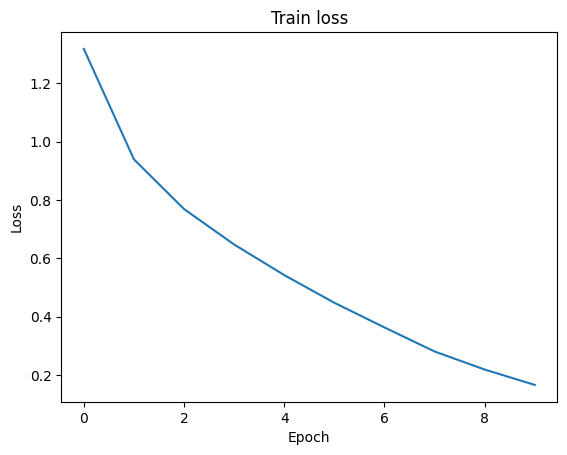

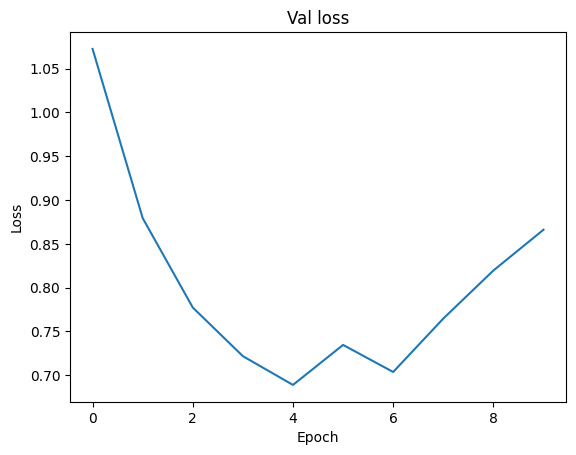

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model4.parameters(), lr=0.001)

losses4 = train_network(model4, train_loader, val_loader, criterion, optimizer, nepoch=10)
results4 = test_network(model4, test_loader)

plot_losses(losses4[0], losses4[1])

Now let's test a base model.

EPOCH 0
Exiting from training early
Test accuracy: 9.960


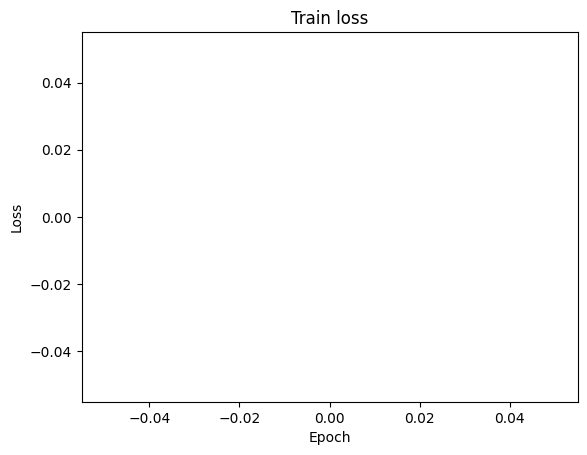

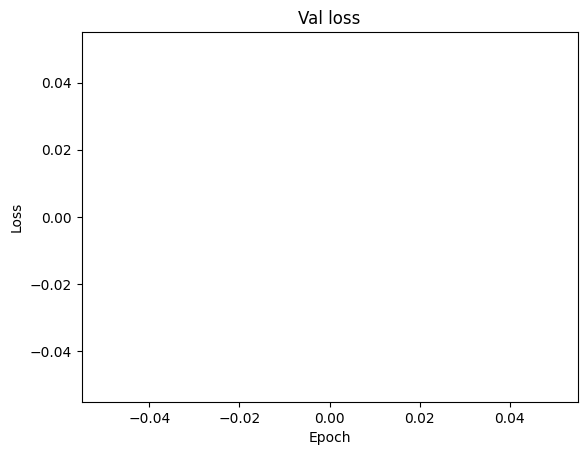

In [20]:
base_model = ModifiedResNet18() # not actually modified
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(base_model.parameters(), lr=0.001)

base_losses = train_network(base_model, train_loader, val_loader, criterion, optimizer, nepoch=10)
base_results = test_network(base_model, test_loader)

plot_losses(base_losses[0], base_losses[1])

Now let's look at the accuracies!

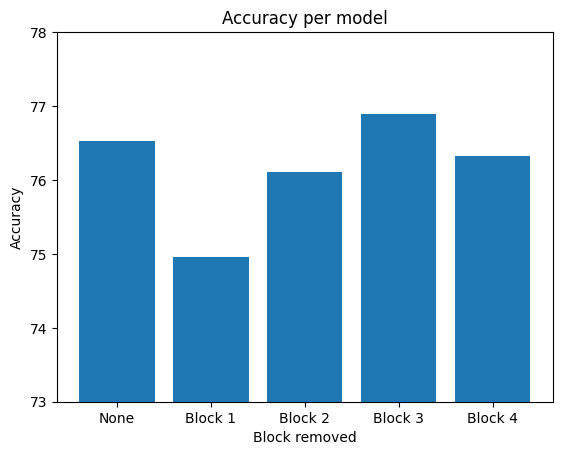

In [ ]:
categories = ['None', 'Block 1', 'Block 2', 'Block 3', 'Block 4']
accuracies = [base_results[0], results1[0], results2[0], results3[0], results4[0]]

plt.bar(categories, accuracies)
plt.ylim(73, 78)
plt.xlabel('Block removed')
plt.ylabel('Accuracy')
plt.title('Accuracy per model')
plt.show()

We see here that, when Block 2 was removed and when Block 4 was removed, the accuracies were similar. Suprisingly when Block 3 was removed, the accuracy increased a little while when Block 1 was removed, the accuracy decreased significantly.

2. Width vs. Depth

Let's create a less deep, less wide, more deep, and more wide model and compare accuracies!

EPOCH 0
 Train loss: 1.40799
   Val loss: 1.17476

EPOCH 1
 Train loss: 1.01152
   Val loss: 0.99171

EPOCH 2
 Train loss: 0.83955
   Val loss: 0.87015

EPOCH 3
 Train loss: 0.72320
   Val loss: 0.83513

EPOCH 4
 Train loss: 0.62698
   Val loss: 0.82380

EPOCH 5
 Train loss: 0.54015
   Val loss: 0.71542

EPOCH 6
 Train loss: 0.45793
   Val loss: 0.75729

EPOCH 7
 Train loss: 0.37981
   Val loss: 0.73568

Test accuracy: 77.140


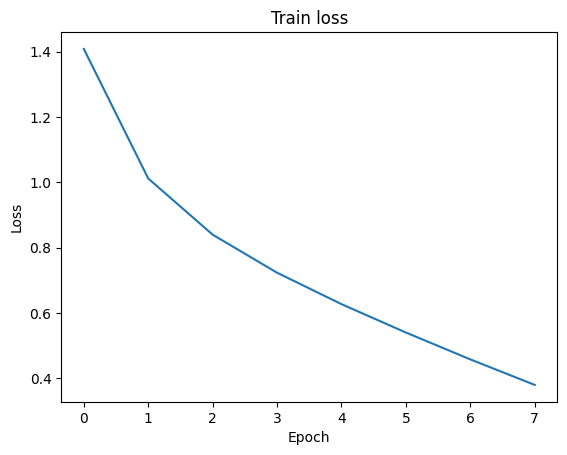

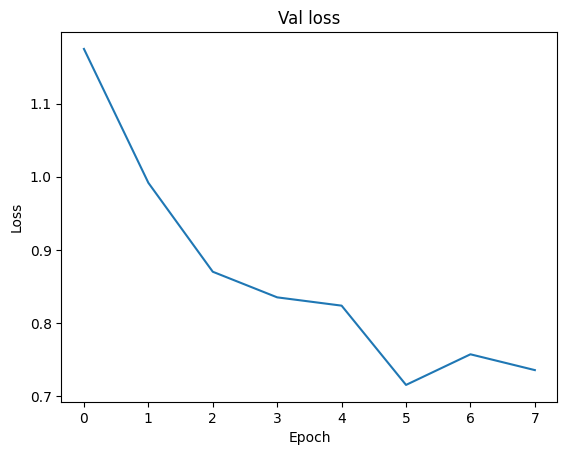

In [ ]:
mw_model = ModifiedResNet18(widths=[72, 144, 288, 576]) # normal width * 1.125
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mw_model.parameters(), lr=0.001)

mw_losses = train_network(mw_model, train_loader, val_loader, criterion, optimizer, nepoch=8)
mw_results = test_network(mw_model, test_loader)

plot_losses(mw_losses[0], mw_losses[1])

EPOCH 0
 Train loss: 1.40908
   Val loss: 1.19472

EPOCH 1
 Train loss: 1.03480
   Val loss: 0.98530

EPOCH 2
 Train loss: 0.86945
   Val loss: 0.88672

EPOCH 3
 Train loss: 0.75702
   Val loss: 0.84938

EPOCH 4
 Train loss: 0.66115
   Val loss: 0.76497

EPOCH 5
 Train loss: 0.58083
   Val loss: 0.74094

EPOCH 6
 Train loss: 0.50003
   Val loss: 0.71972

EPOCH 7
 Train loss: 0.42531
   Val loss: 0.72732

Test accuracy: 75.990


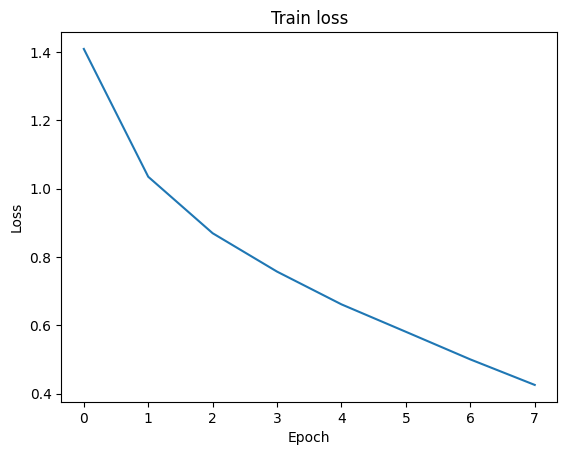

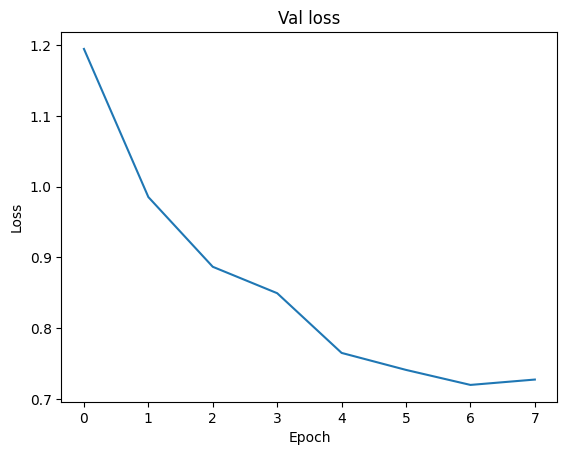

In [ ]:
lw_model = ModifiedResNet18(widths=[56, 112, 224, 448]) # normal width * 0.875
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lw_model.parameters(), lr=0.001)

lw_losses = train_network(lw_model, train_loader, val_loader, criterion, optimizer, nepoch=8)
lw_results = test_network(lw_model, test_loader)

plot_losses(lw_losses[0], lw_losses[1])

EPOCH 0
 Train loss: 1.47696
   Val loss: 1.20308

EPOCH 1
 Train loss: 1.07915
   Val loss: 1.01227

EPOCH 2
 Train loss: 0.90840
   Val loss: 0.90172

EPOCH 3
 Train loss: 0.78348
   Val loss: 0.78413

EPOCH 4
 Train loss: 0.68432
   Val loss: 0.76645

EPOCH 5
 Train loss: 0.62904
   Val loss: 0.73564

EPOCH 6
 Train loss: 0.53469
   Val loss: 0.73279

EPOCH 7
 Train loss: 0.46949
   Val loss: 0.73226

Test accuracy: 77.160


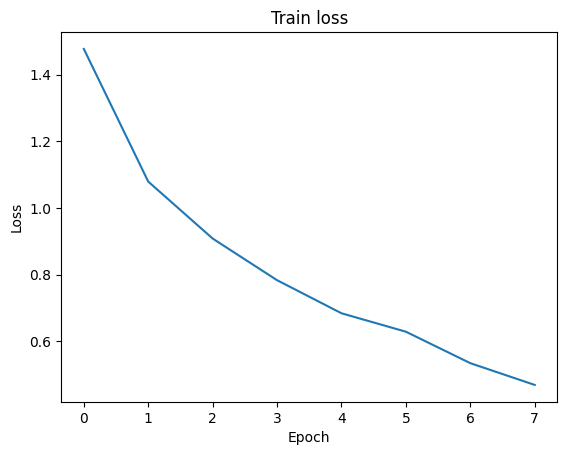

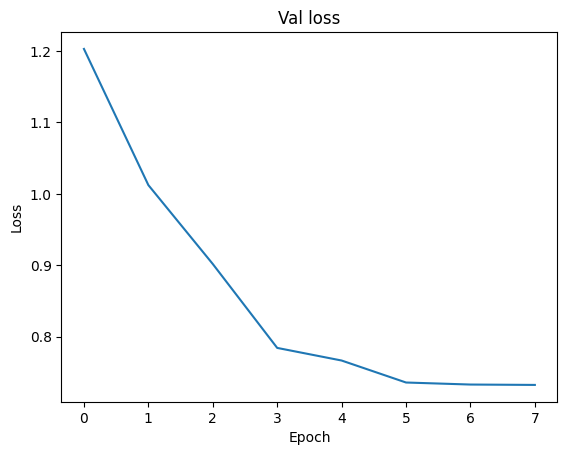

In [ ]:
md_model = ModifiedResNet18(layers=[3, 3, 3, 3])
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(md_model.parameters(), lr=0.001)

md_losses = train_network(md_model, train_loader, val_loader, criterion, optimizer, nepoch=8)
md_results = test_network(md_model, test_loader)

plot_losses(md_losses[0], md_losses[1])

EPOCH 0
 Train loss: 1.32780
   Val loss: 1.08006

EPOCH 1
 Train loss: 0.97474
   Val loss: 0.95551

EPOCH 2
 Train loss: 0.79889
   Val loss: 0.88032

EPOCH 3
 Train loss: 0.68968
   Val loss: 0.79392

EPOCH 4
 Train loss: 0.58418
   Val loss: 0.76718

EPOCH 5
 Train loss: 0.48734
   Val loss: 0.79122

EPOCH 6
 Train loss: 0.40476
   Val loss: 0.84142

EPOCH 7
 Train loss: 0.33677
   Val loss: 0.81936

Test accuracy: 75.160


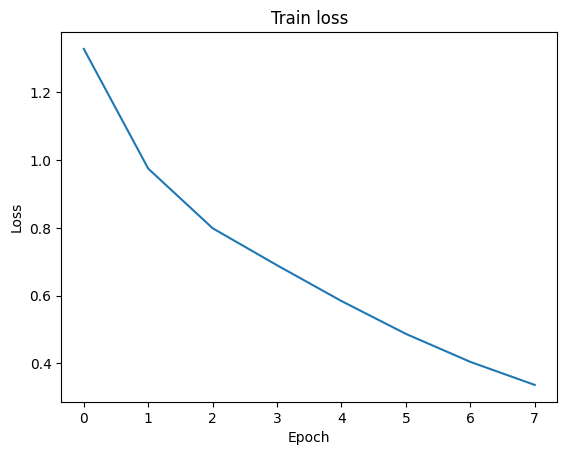

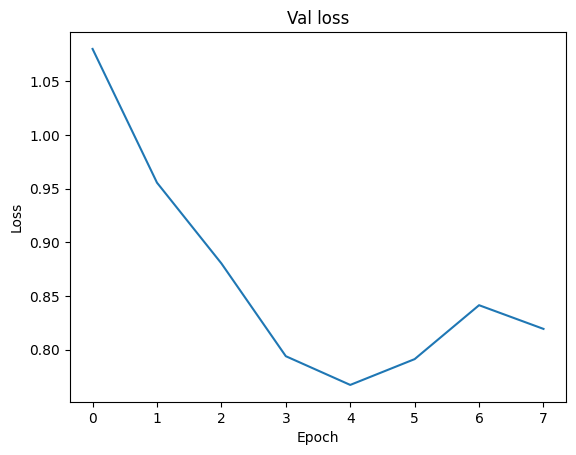

In [ ]:
ld_model = ModifiedResNet18(layers=[1, 1, 1, 1])
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ld_model.parameters(), lr=0.001)

ld_losses = train_network(ld_model, train_loader, val_loader, criterion, optimizer, nepoch=8)
ld_results = test_network(ld_model, test_loader)

plot_losses(ld_losses[0], ld_losses[1])

EPOCH 0
 Train loss: 1.40134
   Val loss: 1.17226

EPOCH 1
 Train loss: 1.02213
   Val loss: 0.94240

EPOCH 2
 Train loss: 0.85469
   Val loss: 0.89749

EPOCH 3
 Train loss: 0.73739
   Val loss: 0.82482

EPOCH 4
 Train loss: 0.63860
   Val loss: 0.81890

EPOCH 5
 Train loss: 0.55592
   Val loss: 0.73019

EPOCH 6
 Train loss: 0.47657
   Val loss: 0.75278

EPOCH 7
 Train loss: 0.39867
   Val loss: 0.73206

Test accuracy: 76.160


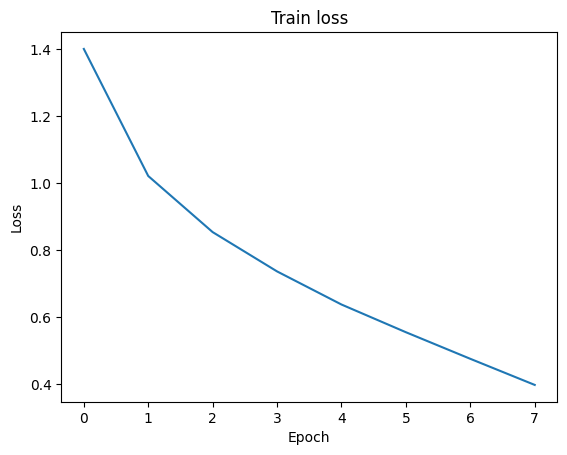

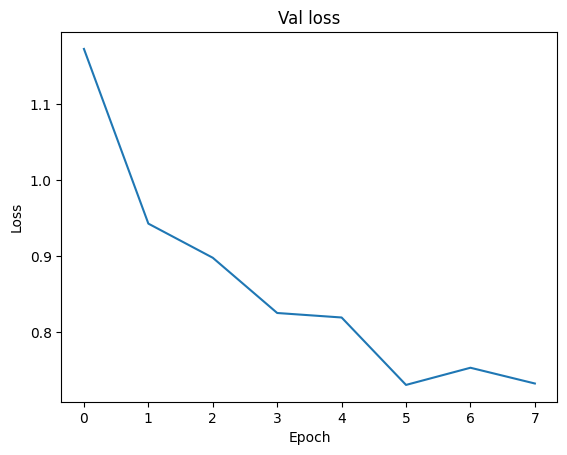

In [ ]:
base_model = ModifiedResNet18() # not actually modified
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(base_model.parameters(), lr=0.001)

base_losses = train_network(base_model, train_loader, val_loader, criterion, optimizer, nepoch=8)
base_results = test_network(base_model, test_loader)

plot_losses(base_losses[0], base_losses[1])

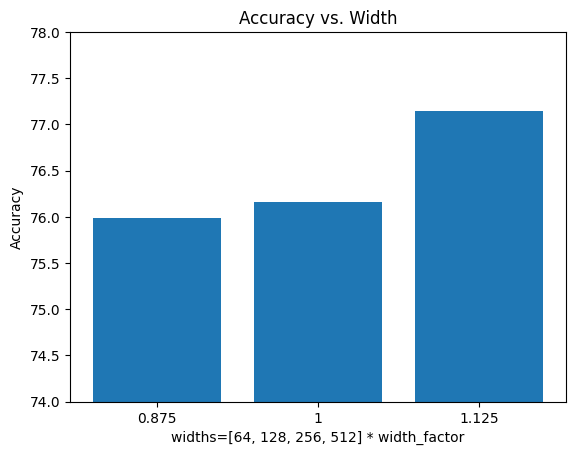

In [ ]:
width_factors = ['0.875', '1', '1.125']
w_accuracies = [75.99, base_results[0], 77.14]

plt.bar(width_factors, w_accuracies)
plt.ylim(74, 78)
plt.xlabel('widths=[64, 128, 256, 512] * width_factor')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Width')
plt.show()

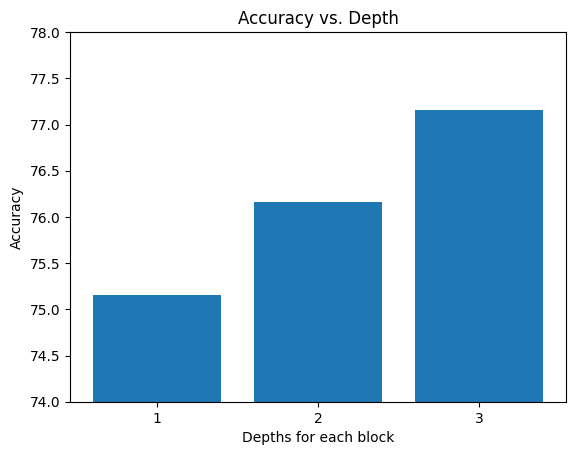

In [ ]:
depths = ['1', '2', '3']
d_accuracies = [ld_results[0], base_results[0], md_results[0]]

plt.bar(depths, d_accuracies)
plt.ylim(74, 78)
plt.xlabel('Depths for each block')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Depth')
plt.show()

These graphs show that there is probably a positive correlation between width and accuracy, as well as between depth and accuracy.

Sources:

github.com/pytorch/vision/blob/main/torchvision/models/resnet.py

### Part B: Robustness & Evaluation Focus

In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
import random

device = torch.device("cpu")
model = models.resnet18(pretrained=True).to(device)
model.eval()


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
def gaussian_noise(img, std=0.2):
    img_np = np.array(img).astype(np.float32) / 255.0
    noise = np.random.normal(0, std, img_np.shape)
    img_np = np.clip(img_np + noise, 0, 1)
    return Image.fromarray((img_np * 255).astype(np.uint8))

def salt_pepper_noise(img, amount=0.05):
    img_np = np.array(img)
    s_vs_p = 0.5
    num_salt = np.ceil(amount * img_np.size * s_vs_p)
    num_pepper = np.ceil(amount * img_np.size * (1.0 - s_vs_p))

    coords = [np.random.randint(0, i, int(num_salt)) for i in img_np.shape[:2]]
    img_np[coords[0], coords[1]] = 255

    coords = [np.random.randint(0, i, int(num_pepper)) for i in img_np.shape[:2]]
    img_np[coords[0], coords[1]] = 0

    return Image.fromarray(img_np)

def gaussian_blur(img, radius=2):
    return img.filter(ImageFilter.GaussianBlur(radius))

corruptions = {
    "Clean": lambda x: x,
    "Gaussian Noise": gaussian_noise,
    "Salt & Pepper": salt_pepper_noise,
    "Gaussian Blur": gaussian_blur
}

In [ ]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])


In [ ]:
ds = tfds.load("imagenet_v2", split="test", shuffle_files=False, as_supervised=True)
ds = ds.take(500)

def convert_tfds_to_pil(ds):
    images, labels = [], []
    for img, label in tfds.as_numpy(ds):
        img_pil = Image.fromarray(img)
        images.append(img_pil)
        labels.append(int(label))
    return images, labels

raw_images, raw_labels = convert_tfds_to_pil(ds)

2025-04-24 09:52:21.605197: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-04-24 09:52:22.018169: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
def evaluate(model, images, labels, corruption_fn):
    correct = 0
    total = len(labels)

    for i in range(0, total, 32):
        batch_imgs = images[i:i+32]
        batch_labels = labels[i:i+32]

        inputs = torch.stack([preprocess(corruption_fn(img)) for img in batch_imgs]).to(device)
        targets = torch.tensor(batch_labels).to(device)

        with torch.no_grad():
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == targets).sum().item()

    return 100.0 * correct / total

In [ ]:
results = {}
for name, fn in corruptions.items():
    acc = evaluate(model, raw_images, raw_labels, fn)
    results[name] = acc
    print(f"{name} Accuracy: {acc:.2f}%")

Clean Accuracy: 54.60%
Gaussian Noise Accuracy: 25.40%
Salt & Pepper Accuracy: 13.40%
Gaussian Blur Accuracy: 42.00%


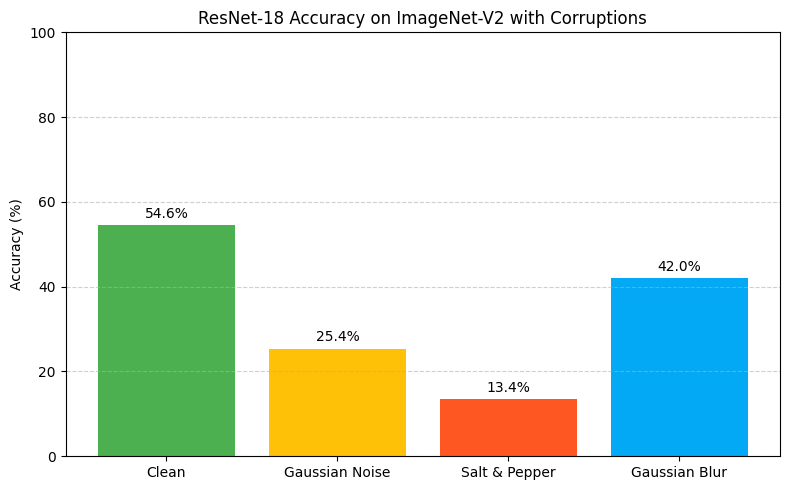

In [ ]:
plt.figure(figsize=(8, 5))
labels = list(results.keys())
values = list(results.values())

bars = plt.bar(labels, values, color=['#4CAF50', '#FFC107', '#FF5722', '#03A9F4'])
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 1, f'{yval:.1f}%', ha='center', va='bottom')

plt.ylabel("Accuracy (%)")
plt.title("ResNet-18 Accuracy on ImageNet-V2 with Corruptions")
plt.ylim(0, 100)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:
ds = tfds.load("imagenet_v2", split="test", shuffle_files=False, as_supervised=True)
example = next(iter(tfds.as_numpy(ds)))
img = Image.fromarray(example[0])

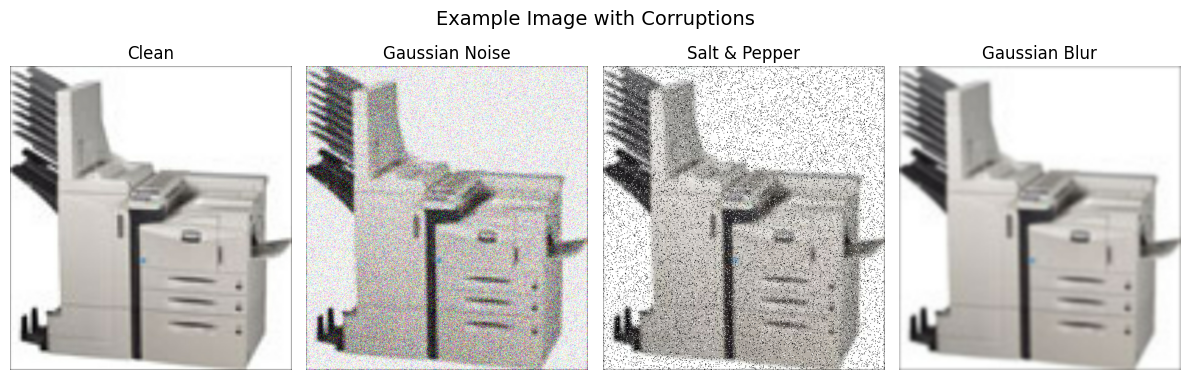

In [ ]:
plt.figure(figsize=(12, 4))
for i, (name, corrupted_img) in enumerate(corruptions.items()):
    plt.subplot(1, 4, i + 1)
    if callable(corrupted_img):
        corrupted_img = corrupted_img(img)
    plt.imshow(np.array(corrupted_img).astype(np.uint8))
    plt.title(name)
    plt.axis("off")
plt.suptitle("Example Image with Corruptions", fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
import json
import urllib.request

url = "https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json"
with urllib.request.urlopen(url) as response:
    class_index = json.load(response)

id_to_label = {int(k): v[1] for k, v in class_index.items()}

print(id_to_label[0])  # tench


tench


242
Top 5 Performing Classes:
schooner: 100.00%
manhole_cover: 100.00%
cougar: 100.00%
ibex: 100.00%
marmot: 100.00%
Bottom 5 Performing Classes:
printer: 33.33%
wardrobe: 33.33%
perfume: 33.33%
car_mirror: 33.33%
trilobite: 33.33%


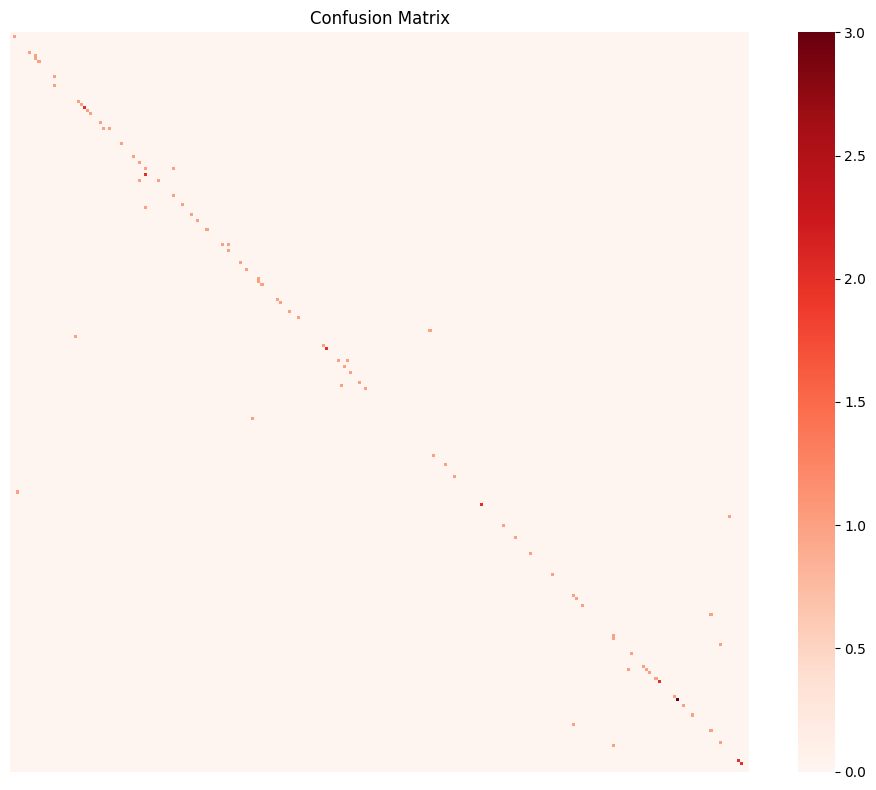

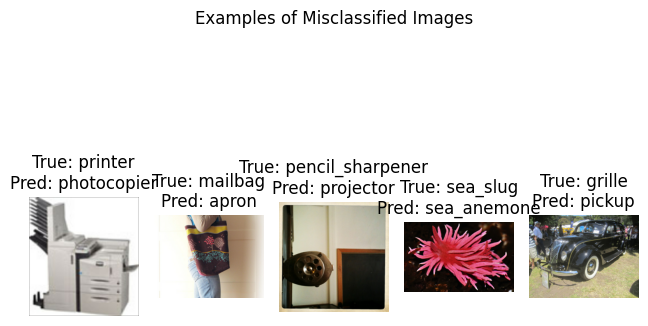

In [ ]:
from collections import defaultdict
import torchvision
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

imagenet_labels = id_to_label

correct_per_class = defaultdict(int)
total_per_class = defaultdict(int)
all_preds = []
all_targets = []

for i in range(0, len(raw_labels), 32):
    batch_imgs = raw_images[i:i+32]
    batch_labels = raw_labels[i:i+32]

    inputs = torch.stack([preprocess(img) for img in batch_imgs]).to(device)
    targets = torch.tensor(batch_labels).to(device)

    with torch.no_grad():
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)

    for label, pred in zip(targets, preds):
        total_per_class[int(label)] += 1
        if pred == label:
            correct_per_class[int(label)] += 1
        all_preds.append(int(pred))
        all_targets.append(int(label))

per_class_acc = {cls: (correct_per_class[cls] / total_per_class[cls]) * 100 
                 for cls in correct_per_class}

sorted_acc = sorted(per_class_acc.items(), key=lambda x: x[1])
print(len(per_class_acc))
bottom_classes = sorted_acc[:5]
top_classes = sorted_acc[-5:]

print("Top 5 Performing Classes:")
for cls, acc in reversed(top_classes):
    print(f"{imagenet_labels[cls]}: {acc:.2f}%")

print("Bottom 5 Performing Classes:")
for cls, acc in bottom_classes:
    print(f"{imagenet_labels[cls]}: {acc:.2f}%")

cm = confusion_matrix(all_targets, all_preds, labels=list(range(242)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[imagenet_labels[i] for i in range(1000)])

plt.figure(figsize=(10, 8))
confused_subset = cm
sns.heatmap(confused_subset, xticklabels=False, yticklabels=False, cmap="Reds", square=True)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

def show_misclassified(raw_images, raw_labels, all_preds, num=5):
    count = 0
    for i in range(len(raw_labels)):
        if raw_labels[i] != all_preds[i]:
            plt.subplot(1, num, count + 1)
            plt.imshow(raw_images[i])
            plt.title(f"True: {imagenet_labels[raw_labels[i]]}\nPred: {imagenet_labels[all_preds[i]]}")
            plt.axis("off")
            count += 1
            if count == num:
                break
    plt.suptitle("Examples of Misclassified Images")
    plt.tight_layout()
    plt.show()

show_misclassified(raw_images, raw_labels, all_preds)


### Part C: Feature Map Visualization (Grad-CAM)

In [21]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

In [43]:

# === def of Grad-CAM===
import torch.nn.functional as F
import cv2
import numpy as np
import matplotlib.pyplot as plt

def generate_and_show_gradcam(model, layer, image, label, class_names, device, layer_name):
    activations = {}
    gradients = {}

    def save_activation(name):
        def hook(module, input, output):
            activations[name] = output.detach()
        return hook

    def save_gradient(name):
        def hook(module, grad_input, grad_output):
            gradients[name] = grad_output[0].detach()
        return hook

    handle_a = layer.register_forward_hook(save_activation("target"))
    handle_g = layer.register_backward_hook(save_gradient("target"))

    model.eval()
    model.zero_grad()
    output = model(image)
    pred_class = output[0].argmax().item()
    score = output[0, pred_class]
    score.backward()

    activation = activations["target"][0]
    gradient = gradients["target"][0]
    weights = gradient.mean(dim=(1, 2))

    gradcam = torch.zeros_like(activation[0])
    for i, w in enumerate(weights):
        gradcam += w * activation[i]
    gradcam = F.relu(gradcam)
    gradcam = gradcam - gradcam.min()
    gradcam = gradcam / gradcam.max()
    gradcam_np = gradcam.cpu().numpy()

    gradcam_np = gradcam_np ** 1.5
    gradcam_np = np.nan_to_num(gradcam_np)
    gradcam_np = np.clip(gradcam_np, 0, 1)

    img = image.cpu().squeeze().permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)

    heatmap = cv2.applyColorMap(np.uint8(255 * gradcam_np), cv2.COLORMAP_TURBO)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.float32(heatmap) / 255

    overlay = 0.7 * img + 0.3 * heatmap
    overlay = np.clip(overlay, 0, 1)


    plt.imshow(overlay)
    plt.title(f"{layer_name}: True={class_names[label.item()]}, Pred={class_names[pred_class]}")
    plt.axis('off')
    plt.show()

    handle_a.remove()
    handle_g.remove()


In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [45]:
# === Loading test image for Grad-CAM visualization ===

data_iter = iter(test_loader)
image, label = next(data_iter)
image = image[:1].to(device)
label = label[:1]


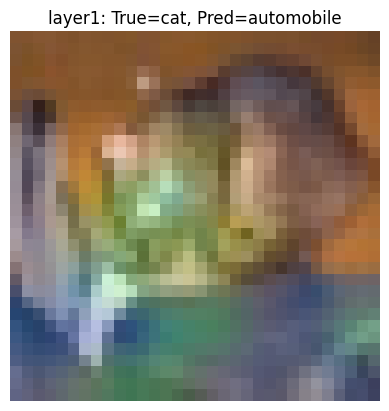

In [46]:
generate_and_show_gradcam(base_model, base_model.layer1[0].conv2, image, label, class_names, device, layer_name='layer1')

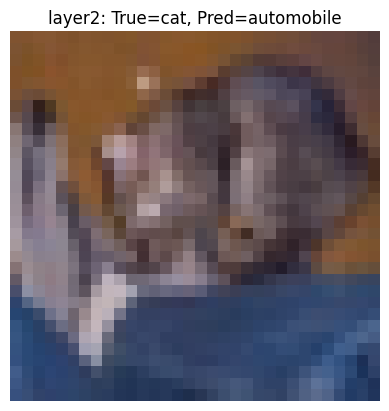

In [47]:
generate_and_show_gradcam(base_model, base_model.layer2[0].conv2, image, label, class_names, device, layer_name='layer2')

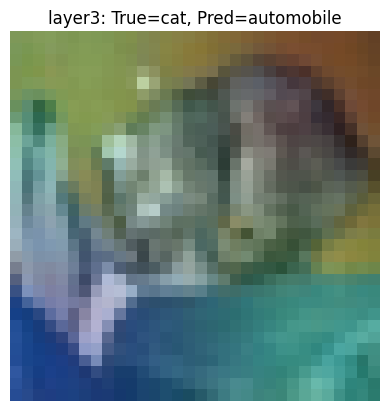

In [48]:
generate_and_show_gradcam(base_model, base_model.layer3[0].conv2, image, label, class_names, device, layer_name='layer3')

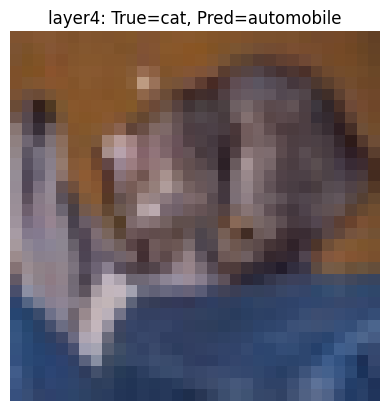

In [49]:
generate_and_show_gradcam(base_model, base_model.layer4[1].conv2, image, label, class_names, device, layer_name='layer4')

Class: cat


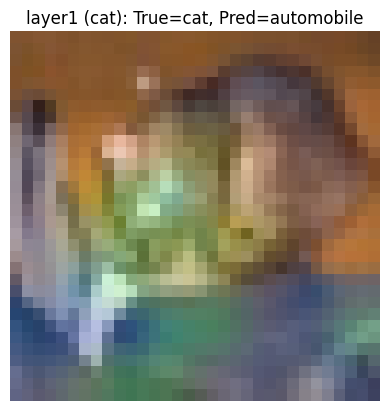

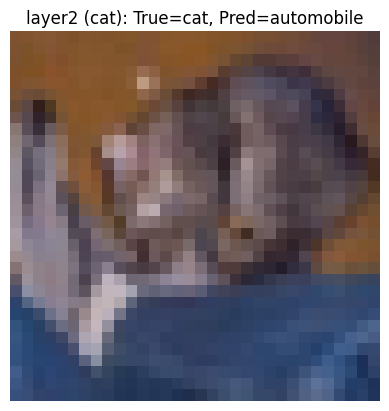

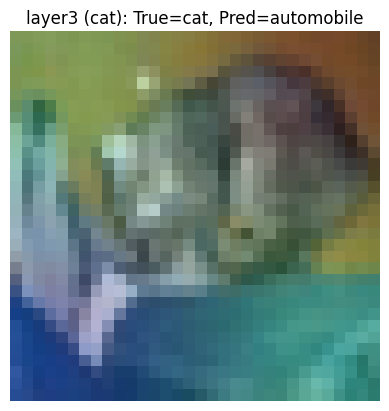

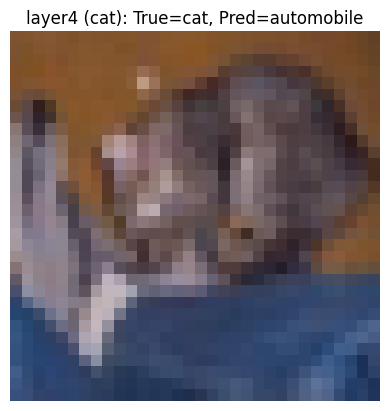

Class: dog


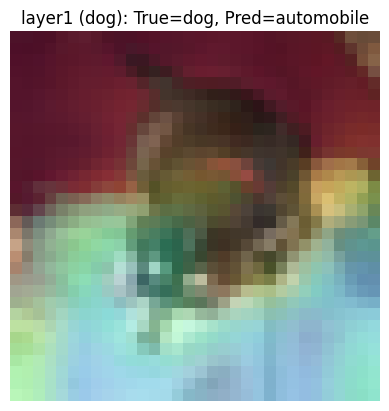

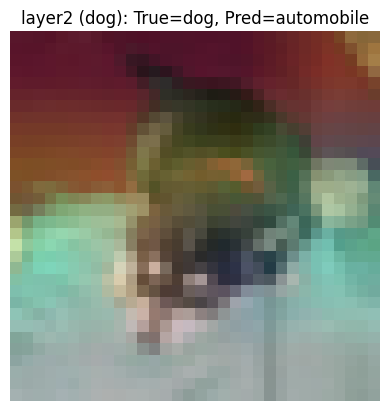

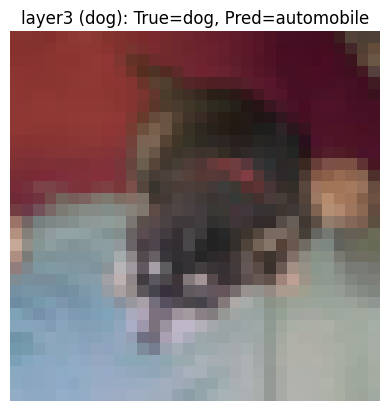

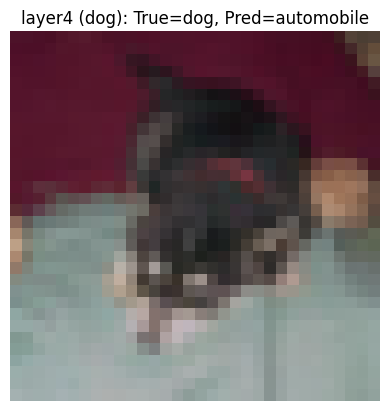

Class: truck


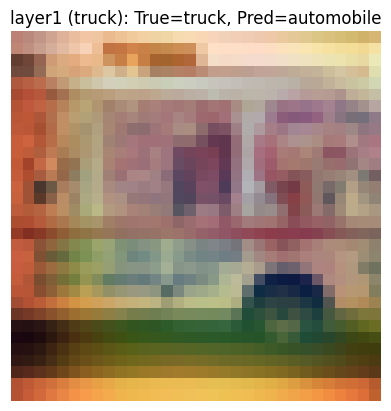

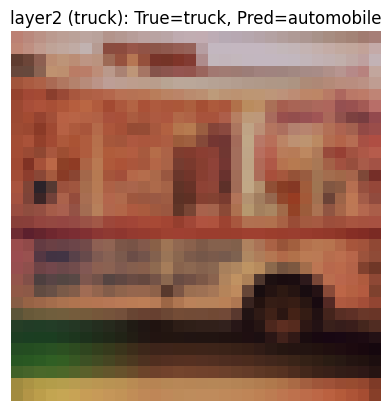

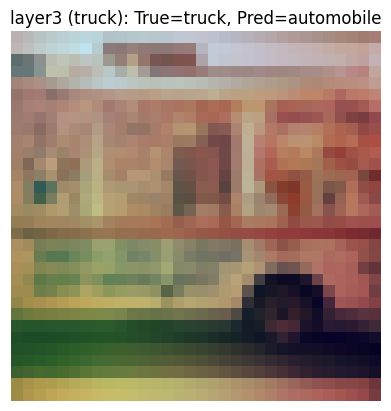

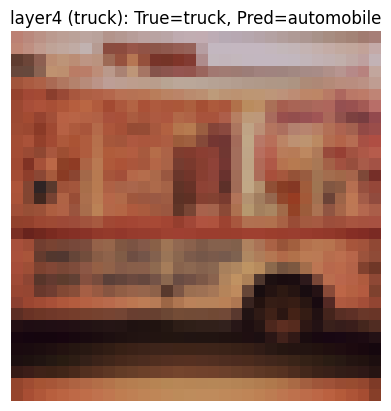

In [50]:
target_classes = ['cat', 'dog', 'truck']
class_to_idx = {name: idx for idx, name in enumerate(class_names)}

selected_images = {}
for name in target_classes:
    idx = class_to_idx[name]
    for img, lbl in test_loader:
        if lbl[0].item() == idx:
           selected_images[name] = (img[:1].to(device), lbl[:1])
           break

layer_targets = {
    "layer1": base_model.layer1[0].conv2,
    "layer2": base_model.layer2[0].conv2,
    "layer3": base_model.layer3[0].conv2,
    "layer4": base_model.layer4[1].conv2
}

for class_name, (img, lbl) in selected_images.items():
    print(f"Class: {class_name}")
    for lname, layer in layer_targets.items():
        generate_and_show_gradcam(base_model, layer, img, lbl, class_names, device, layer_name=f"{lname} ({class_name})")

generate_and_show_gradcam(...) making .png file

In [54]:
def generate_and_save_gradcam(model, layer, image, label, class_names, device, layer_name, class_name):
    import torch.nn.functional as F
    import numpy as np
    import cv2
    import matplotlib.pyplot as plt
    import os

    activations = {}
    gradients = {}

    def save_activation(name):
        def hook(module, input, output):
            activations[name] = output.detach()
        return hook

    def save_gradient(name):
        def hook(module, grad_input, grad_output):
            gradients[name] = grad_output[0].detach()
        return hook

    handle_a = layer.register_forward_hook(save_activation("target"))
    handle_g = layer.register_backward_hook(save_gradient("target"))

    model.eval()
    model.zero_grad()
    output = model(image)
    pred_class = output[0].argmax().item()
    score = output[0, pred_class]
    score.backward()

    activation = activations["target"][0]
    gradient = gradients["target"][0]
    weights = gradient.mean(dim=(1, 2))

    gradcam = torch.zeros_like(activation[0])
    for i, w in enumerate(weights):
        gradcam += w * activation[i]
    gradcam = F.relu(gradcam)
    gradcam = gradcam - gradcam.min()
    gradcam = gradcam / gradcam.max()
    gradcam_np = gradcam.cpu().numpy()

    gradcam_np = gradcam_np ** 1.5
    gradcam_np = np.nan_to_num(gradcam_np)
    gradcam_np = np.clip(gradcam_np, 0, 1)

    img = image.cpu().squeeze().permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)

    heatmap = cv2.applyColorMap(np.uint8(255 * gradcam_np), cv2.COLORMAP_TURBO)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.float32(heatmap) / 255

    overlay = 0.7 * img + 0.3 * heatmap
    overlay = np.clip(overlay, 0, 1)


    plt.imshow(overlay)
    plt.title(f"{layer_name}: True={class_names[label.item()]}, Pred={class_names[pred_class]}")
    plt.axis('off')
    os.makedirs("results", exist_ok=True)
    filename = f"results/{class_name}_{layer_name}.png"
    plt.savefig(filename, bbox_inches='tight')
    plt.close()

    handle_a.remove()
    handle_g.remove()


In [55]:
for class_name, (img, lbl) in selected_images.items():
    print(f"Saving Grad-CAM for class: {class_name}")
    for lname, layer in layer_targets.items():
        generate_and_save_gradcam(base_model, layer, img, lbl, class_names, device, layer_name=lname, class_name=class_name)


Saving Grad-CAM for class: cat
Saving Grad-CAM for class: dog
Saving Grad-CAM for class: truck


In [ ]:
import os
os.makedirs("results", exist_ok=True)